<a href="https://colab.research.google.com/github/shiwangi27/googlecolab/blob/main/openai_triton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install triton

     |████████████████████████████████| 15.2 MB 36 kB/s 


In [ ]:
def next_power_of_2(n):
    n -= 1
    n |= n >> 1
    n |= n >> 2
    n |= n >> 4
    n |= n >> 8
    n |= n >> 16
    n += 1
    return n


In [ ]:
import triton
import triton.language as tl

@triton.jit
def _softmax(Y, X, stride_xm, stride_ym, M, N, **meta):
    # row index
    m = tl.program_id(0)
    # col indices
    # here BLOCK is the smallest power of two greater than `N`
    n = tl.arange(0, meta['BLOCK'])
    # the memory address of all the elements
    # that we want to load can be computed as follows
    X = X + m * stride_xm + n
    x = tl.load(X, mask=n < N, other=-float('inf'))
    # Substract maximum for numerical stability
    z = x - tl.max(x, axis=0)
    # Note that exponentials in Triton are fast
    # but approximate (i.e., think __expf in CUDA)
    num = tl.exp(z)
    denom = tl.sum(num, axis=0)
    y = num / denom
    # Write back to Y
    Y = Y + m * stride_ym + n
    tl.store(Y, y, mask=n < N)


@triton.jit
def _relu(Y, X, stride_xm, stride_ym, M, N, **meta):
  # row index
    m = tl.program_id(0)
    # col indices
    # here BLOCK is the smallest power of two greater than `N`
    n = tl.arange(0, meta['BLOCK'])
    # the memory address of all the elements
    # that we want to load can be computed as follows
    X = X + m * stride_xm + n
    x = tl.load(X, mask=n < N, other=-float('inf'))
    
    # Relu 
    y = tl.maximum(x, 0.0)

    # Write back to Y
    Y = Y + m * stride_ym + n
    tl.store(Y, y, mask=n < N)


@triton.jit
def _sigmoid(Y, X, stride_xm, stride_ym, M, N, **meta):
    # row index
    m = tl.program_id(0)
    # col indices
    # here BLOCK is the smallest power of two greater than `N`
    n = tl.arange(0, meta['BLOCK'])
    # the memory address of all the elements
    # that we want to load can be computed as follows
    X = X + m * stride_xm + n
    x = tl.load(X, mask=n < N, other=-float('inf'))
    
    # Sigmoid 
    exp = tl.exp(-x)
    y = 1 / (1 + exp)

    # Write back to Y
    Y = Y + m * stride_ym + n
    tl.store(Y, y, mask=n < N)
    

In [ ]:

def softmax(x):
    M, N = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK = next_power_of_2(N)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK >= 2048: num_warps = 8
    if BLOCK >= 4096: num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The launch grid is simple: we have one kernel instance per row of the input matrix
    _softmax[(M, )](y, x, x.stride(0), y.stride(0), M, N, num_warps=num_warps, BLOCK=BLOCK)
    return y

def relu(x):
    M, N = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK = next_power_of_2(N)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK >= 2048: num_warps = 8
    if BLOCK >= 4096: num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The launch grid is simple: we have one kernel instance per row of the input matrix
    _relu[(M, )](y, x, x.stride(0), y.stride(0), M, N, num_warps=num_warps, BLOCK=BLOCK)
    return y

def sigmoid(x):
    M, N = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK = next_power_of_2(N)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK >= 2048: num_warps = 8
    if BLOCK >= 4096: num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The launch grid is simple: we have one kernel instance per row of the input matrix
    _sigmoid[(M, )](y, x, x.stride(0), y.stride(0), M, N, num_warps=num_warps, BLOCK=BLOCK)
    return y

In [ ]:
x = torch.randn(100, 100, device='cuda', dtype=torch.float32)
relu(x)

tensor([[0.0000, 0.8540, 0.0000,  ..., 0.4478, 0.0000, 1.3876],
        [0.2218, 0.0000, 0.1983,  ..., 0.0000, 0.7606, 0.0000],
        [1.3607, 1.3590, 0.0000,  ..., 0.1590, 0.0000, 0.4678],
        ...,
        [0.0000, 0.6066, 0.5151,  ..., 0.0000, 0.0000, 0.8314],
        [0.8935, 0.2409, 0.0000,  ..., 0.0000, 0.3104, 0.9568],
        [0.1568, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
torch.relu(x)

tensor([[0.0000, 0.8540, 0.0000,  ..., 0.4478, 0.0000, 1.3876],
        [0.2218, 0.0000, 0.1983,  ..., 0.0000, 0.7606, 0.0000],
        [1.3607, 1.3590, 0.0000,  ..., 0.1590, 0.0000, 0.4678],
        ...,
        [0.0000, 0.6066, 0.5151,  ..., 0.0000, 0.0000, 0.8314],
        [0.8935, 0.2409, 0.0000,  ..., 0.0000, 0.3104, 0.9568],
        [0.1568, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
sigmoid(x)

tensor([[0.1082, 0.7014, 0.2970,  ..., 0.6101, 0.3600, 0.8002],
        [0.5552, 0.2010, 0.5494,  ..., 0.4796, 0.6815, 0.1123],
        [0.7959, 0.7956, 0.2000,  ..., 0.5397, 0.1757, 0.6149],
        ...,
        [0.4810, 0.6472, 0.6260,  ..., 0.1944, 0.3924, 0.6967],
        [0.7096, 0.5599, 0.1938,  ..., 0.4543, 0.5770, 0.7225],
        [0.5391, 0.2901, 0.3627,  ..., 0.4326, 0.2999, 0.3227]],
       device='cuda:0')

In [ ]:
torch.sigmoid(x)

tensor([[0.1082, 0.7014, 0.2970,  ..., 0.6101, 0.3600, 0.8002],
        [0.5552, 0.2010, 0.5494,  ..., 0.4796, 0.6815, 0.1123],
        [0.7959, 0.7956, 0.2000,  ..., 0.5397, 0.1757, 0.6149],
        ...,
        [0.4810, 0.6472, 0.6260,  ..., 0.1944, 0.3924, 0.6967],
        [0.7096, 0.5599, 0.1938,  ..., 0.4543, 0.5770, 0.7225],
        [0.5391, 0.2901, 0.3627,  ..., 0.4326, 0.2999, 0.3227]],
       device='cuda:0')

### Benchmarking

In [ ]:
# Compute the row-wise softmax of x
@torch.jit.script
def naive_softmax(x):
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read 2MN elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(x)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read 2MN elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 7MN elements ; wrote 3MN + 2M elements
    return ret

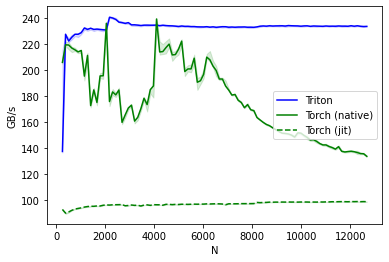

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  137.464082      205.926154    92.925911
1     384.0  227.555555      219.428568    90.104488
2     512.0  222.344357      219.275613    91.006425
3     640.0  225.287038      216.934793    92.252251
4     768.0  227.555555      215.578943    93.234383
..      ...         ...             ...          ...
93  12160.0  233.718862      137.275408    98.930126
94  12288.0  234.065855      136.628213    98.996979
95  12416.0  233.657111      135.875261    98.884565
96  12544.0  233.470063      135.705367    98.968000
97  12672.0  233.606284      133.741423    98.881559

[98 rows x 4 columns]


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch-native', 'torch-jit'],  # possible values for `line_arg``
        line_names=["Triton", "Torch (native)", "Torch (jit)"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096}  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)


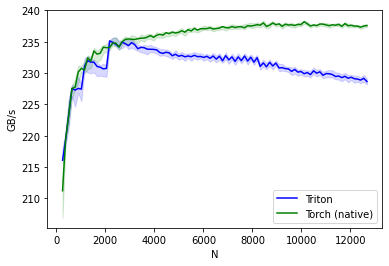

softmax-performance:
          N      Triton  Torch (native)
0     256.0  216.112112      211.236097
1     384.0  219.428568      219.551087
2     512.0  223.481677      223.386456
3     640.0  227.555552      227.555552
4     768.0  227.292483      227.753259
..      ...         ...             ...
93  12160.0  229.108901      237.508148
94  12288.0  229.059253      237.498573
95  12416.0  228.891079      237.329597
96  12544.0  229.175470      237.519534
97  12672.0  228.662300      237.579695

[98 rows x 3 columns]


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch-native'],  # possible values for `line_arg``
        line_names=["Triton", "Torch (native)"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096}  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: relu(x))
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)

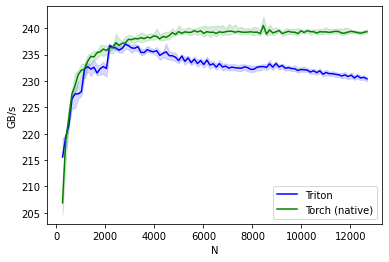

softmax-performance:
          N      Triton  Torch (native)
0     256.0  215.578957      206.901344
1     384.0  219.428568      218.696335
2     512.0  221.592553      222.911566
3     640.0  226.611349      227.555552
4     768.0  227.555555      229.146849
..      ...         ...             ...
93  12160.0  230.568278      239.301987
94  12288.0  230.976601      239.182490
95  12416.0  230.572250      239.056563
96  12544.0  230.694256      239.213657
97  12672.0  230.399998      239.354552

[98 rows x 3 columns]


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch-native'],  # possible values for `line_arg``
        line_names=["Triton", "Torch (native)"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096}  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.sigmoid(x))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: sigmoid(x))
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)